In [9]:
import numpy as np 
import pandas as pd 
import os 
import time

In [30]:
data = pd.read_csv("bitcoin.csv")
print(data.head())

                  Date  btc_market_price  btc_total_bitcoins  btc_market_cap  \
0  2010-02-23 00:00:00               0.0           2110700.0             0.0   
1  2010-02-24 00:00:00               0.0           2120200.0             0.0   
2  2010-02-25 00:00:00               0.0           2127600.0             0.0   
3  2010-02-26 00:00:00               0.0           2136100.0             0.0   
4  2010-02-27 00:00:00               0.0           2144750.0             0.0   

   btc_trade_volume  btc_blocks_size  btc_avg_block_size  \
0               0.0              0.0            0.000216   
1               0.0              0.0            0.000282   
2               0.0              0.0            0.000227   
3               0.0              0.0            0.000319   
4               0.0              0.0            0.000223   

   btc_n_orphaned_blocks  btc_n_transactions_per_block  \
0                    0.0                           1.0   
1                    0.0                  

In [31]:
data.columns

Index(['Date', 'btc_market_price', 'btc_total_bitcoins', 'btc_market_cap',
       'btc_trade_volume', 'btc_blocks_size', 'btc_avg_block_size',
       'btc_n_orphaned_blocks', 'btc_n_transactions_per_block',
       'btc_median_confirmation_time', 'btc_hash_rate', 'btc_difficulty',
       'btc_miners_revenue', 'btc_transaction_fees',
       'btc_cost_per_transaction_percent', 'btc_cost_per_transaction',
       'btc_n_unique_addresses', 'btc_n_transactions',
       'btc_n_transactions_total', 'btc_n_transactions_excluding_popular',
       'btc_n_transactions_excluding_chains_longer_than_100',
       'btc_output_volume', 'btc_estimated_transaction_volume',
       'btc_estimated_transaction_volume_usd'],
      dtype='object')

In [32]:
bitcoin_data = data.copy()

bitcoin_data= bitcoin_data.sort_values('Date')
bitcoin_data['Date'] = pd.to_datetime(bitcoin_data['Date'])

train_size = int(len(bitcoin_data) * 0.8)
train, test = bitcoin_data.iloc[:train_size], bitcoin_data.iloc[train_size:]


/var/folders/gp/4xjtl1pj7tb99kzw8xdcpdm00000gn/T/ipykernel_1595/936191938.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method="ffill").dropna()
/var/folders/gp/4xjtl1pj7tb99kzw8xdcpdm00000gn/T/ipykernel_1595/936191938.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag{l}"] = df[col].shift(l)
/var/folders/gp/4xjtl1pj7tb99kzw8xdcpdm00000gn/T/ipykernel_1595/936191938.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfr

Test RMSE Ridge: 668.6459
Test RMSE Lasso: 670.9282
Number of features kept by Lasso: 113 out of 134


/Users/medhadhir/Desktop/UIUC/CS 598 PSL/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.191e+05, tolerance: 1.277e+04
  model = cd_fast.enet_coordinate_descent(


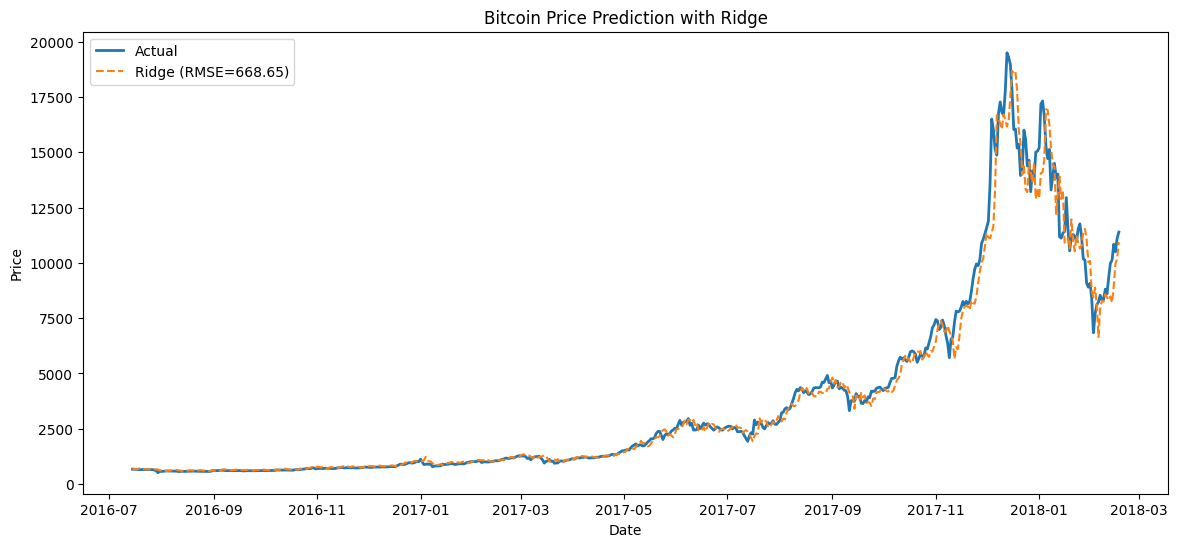

Top features chosen by Lasso:
btc_market_price                                            237.865819
btc_n_transactions_total_lag1                               101.482409
btc_market_price_lag2                                        33.911609
btc_market_price_lag3                                        32.920813
btc_cost_per_transaction                                     14.151047
btc_n_transactions                                           11.180722
btc_hash_rate_lag4                                           10.955188
btc_miners_revenue_lag2                                      10.682290
btc_n_transactions_per_block_lag1                             9.571430
btc_hash_rate_lag1                                            8.988386
btc_hash_rate_lag5                                            8.539809
btc_miners_revenue_lag3                                       8.519503
btc_difficulty_lag2                                           8.251082
btc_n_transactions_excluding_chains_longer_than

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# ----------------------------
# 1. Load & clean data
# ----------------------------
data = pd.read_csv("bitcoin.csv")
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date').reset_index(drop=True)

# Fill missing values (forward fill)
data = data.fillna(method="ffill").dropna()

# ----------------------------
# 2. Create supervised dataset
# ----------------------------
lag_window = 5
horizon = 3
def make_supervised(df, lag=lag_window, horizon=horizon, target_col="btc_market_price"):
    df = df.copy()
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # lag every numeric feature
    for col in numeric_cols:
        for l in range(1, lag + 1):
            df[f"{col}_lag{l}"] = df[col].shift(l)
    
    # target = future price
    df['target'] = df[target_col].shift(-horizon)
    return df.dropna()


df_supervised = make_supervised(data, lag=lag_window, horizon=horizon)

# ----------------------------
# 3. Train/test split
# ----------------------------
train_size = int(len(df_supervised) * 0.8)
train = df_supervised.iloc[:train_size]
test = df_supervised.iloc[train_size:]

X_train = train.drop(columns=['Date', 'target', 'btc_n_orphaned_blocks', 'btc_blocks_size', 'btc_median_confirmation_time', 'btc_n_transactions_total'])
y_train = train['target']
X_test = test.drop(columns=['Date', 'target', 'btc_n_orphaned_blocks', 'btc_blocks_size', 'btc_median_confirmation_time', 
                           'btc_n_transactions_total' ])
y_test = test['target']

# ----------------------------
# 4. Scale features
# ----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ----------------------------
# 5. Train Ridge & Lasso
# ----------------------------
ridge = Ridge(alpha=0.8)
lasso = Lasso(alpha=0.01, max_iter=5000)  # small alpha for feature selection

ridge.fit(X_train_scaled, y_train)
lasso.fit(X_train_scaled, y_train)

ridge_preds = ridge.predict(X_test_scaled)
lasso_preds = lasso.predict(X_test_scaled)

ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_preds))
lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_preds))

print(f"Test RMSE Ridge: {ridge_rmse:.4f}")
print(f"Test RMSE Lasso: {lasso_rmse:.4f}")
print(f"Number of features kept by Lasso: {(lasso.coef_ != 0).sum()} out of {len(lasso.coef_)}")

# ----------------------------
# 6. Plot actual vs predictions
# ----------------------------
plt.figure(figsize=(14,6))
plt.plot(test['Date'], y_test, label="Actual", linewidth=2)
plt.plot(test['Date'], ridge_preds, label=f"Ridge (RMSE={ridge_rmse:.2f})", linestyle="--")
plt.title("Bitcoin Price Prediction with Ridge")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


feature_importance = pd.Series(lasso.coef_, index=X_train.columns)
important_features = feature_importance[feature_importance != 0].sort_values(ascending=False)

print("Top features chosen by Lasso:")
print(important_features.head(20))



Test RMSE (no horizon shift, with imputation): 760.87


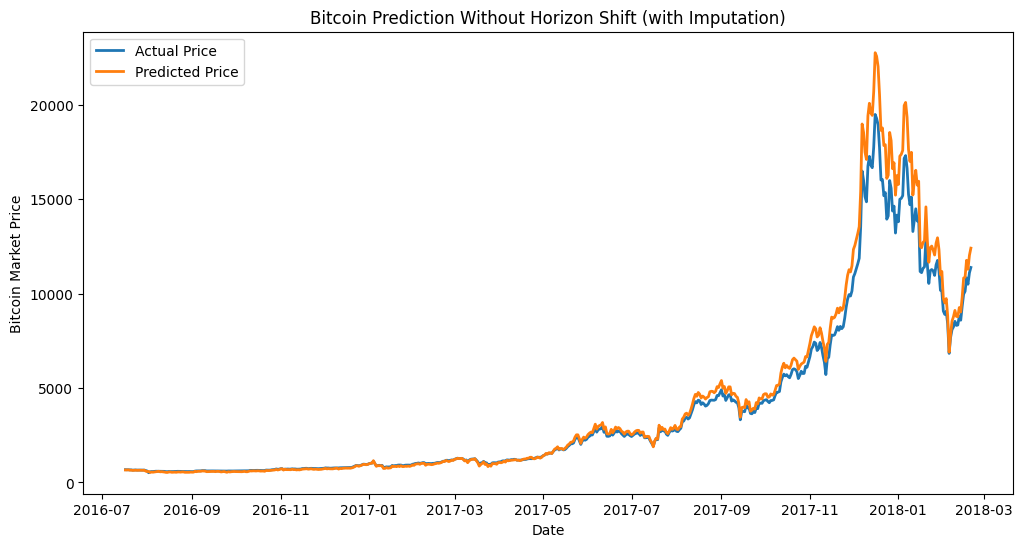

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
import numpy as np


data = pd.read_csv("bitcoin.csv") 
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')


df = data.copy()
df['target'] = df['btc_market_price']

train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

X_train = train.drop(columns=['Date', 'btc_market_price', 'target'])
y_train = train['target']
X_test = test.drop(columns=['Date', 'btc_market_price', 'target'])
y_test = test['target']


imputer = SimpleImputer(strategy="median") 
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)


model = Ridge(alpha=1.0)
model.fit(X_train_scaled, y_train)


preds = model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"Test RMSE (no horizon shift, with imputation): {rmse:.2f}")


plt.figure(figsize=(12,6))
plt.plot(test['Date'], y_test, label="Actual Price", linewidth=2)
plt.plot(test['Date'], preds, label="Predicted Price", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Bitcoin Market Price")
plt.title("Bitcoin Prediction Without Horizon Shift (with Imputation)")
plt.legend()
plt.show()
